# Лабораторная работа №2
# Обучение персептрона

Выполнили Андрей Зимин и Андрей Жилин

## Загрузка библиотек

In [22]:
import qrcode
import numpy as np
from matplotlib import pyplot as plt
import random
import string
from typing import Callable, List, Union
from numpy.typing import NDArray
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as rec
from sklearn.metrics import precision_score as pre
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator

## Служебные методы 

In [3]:
CMAP = 'magma'

def create_code():
  s = ''.join(random.choices(string.ascii_lowercase, k=14))
  pil_img = qrcode.make(s, box_size=1, border=0,)
  np_img = np.array(pil_img.getdata()).reshape(pil_img.size[0], pil_img.size[1], 1)
  np_array = np.concatenate(np.concatenate(np_img))//255
  return np_array

def create_noise():
  return np.array([random.randint(0, 1) for i in range(441)])

def reshape_code(qr):
  s = int((qr.shape[0])**0.5)
  return qr.reshape(s, s)

def show_code(qr, vmin=0, vmax=1, colorbar=False):
  fig, ax = plt.subplots(1, 1, figsize=(4, 4))
  plt.setp(ax, xticklabels=[], yticklabels=[])
  ax.axis("off")
  plt.imshow(reshape_code(qr), cmap=CMAP, vmin=vmin, vmax=vmax)
  if colorbar:
    plt.colorbar()

def crash_code(qr, alpha):
  for i in range(qr.shape[0]):
    if random.random() <= alpha:
      qr[i] = int(not qr[i])
  return qr

def plot_codes(X, y_true=None, y_pred=None, vmin=0, vmax=1):
  fig, ax = plt.subplots(1, X.shape[0], figsize=(3*X.shape[0], 2))
  plt.setp(ax, xticklabels=[], yticklabels=[])

  for i in range(X.shape[0]):
    title = ""
    if y_true is not None:
      title += f"Real: {bool(y_true[i])}\n"
    if y_pred is not None:
      title += f"Predict: {bool(int(y_pred[i]))}"
    ax[i].axis("off")
    ax[i].title.set_text(title)
    ax[i].title.set_size(25)
    ax[i].imshow(reshape_code(X[i, :]), cmap=CMAP, vmin=vmin, vmax=vmax)

def shuffle(X, y):
  n = len(y)
  a = [(random.random(), X[i, :], y[i]) for i in range(n)]
  a.sort()
  new_X = np.array([a[i][1] for i in range(n)])
  new_y = np.array([a[i][2] for i in range(n)])
  return new_X, new_y

## Шаг 0. Общие рекомендации.

Для генерации QR кода рекомендуется использовать библиотеку segno. Например, сохранить в текстовый файл картинку QR кода (матрицу черно-белых пикселей, записанных единицами и нулями).

Здесь мы использовали библиотеку qrcode, потому что sengo не заработала. Создаётся QR-code в формате PLT image, затем переводится в массив numpy. С таким массивом удобно работать дальше, и достаточно легко отрисовать через pyplot.imshow()  

Для этого мы реализовали функции создания, преобразования и отрисовки (их можно найти выше). 

## Шаг 1. Определение минимальной длины QR кода

(np.float64(-0.5), np.float64(20.5), np.float64(20.5), np.float64(-0.5))

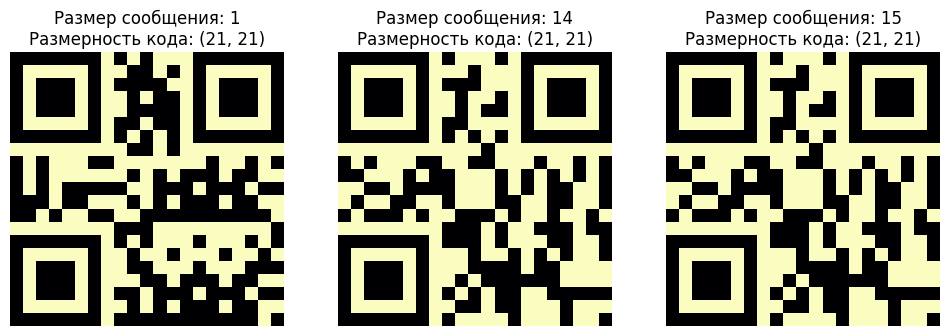

In [4]:
s1 = ''.join(random.choices(string.ascii_lowercase, k=1))
s2 = ''.join(random.choices(string.ascii_lowercase, k=14))
s3 = ''.join(random.choices(string.ascii_lowercase, k=15))
pil_img1 = qrcode.make(s1, box_size=1, border=0,)
pil_img2 = qrcode.make(s2, box_size=1, border=0,)
pil_img3 = qrcode.make(s2, box_size=1, border=0,)

fig, ax = plt.subplots(1, 3, figsize=(12, 30))
plt.setp(ax, xticklabels=[], yticklabels=[])

ax[0].imshow(pil_img1, cmap=CMAP)
ax[0].set_title(f"Размер сообщения: {len(s1)}\nРазмерность кода: {pil_img1.size}")
ax[0].axis("off")
ax[1].imshow(pil_img2, cmap=CMAP)
ax[1].set_title(f"Размер сообщения: {len(s2)}\nРазмерность кода: {pil_img2.size}")
ax[1].axis("off")
ax[2].imshow(pil_img3, cmap=CMAP)
ax[2].set_title(f"Размер сообщения: {len(s3)}\nРазмерность кода: {pil_img3.size}")
ax[2].axis("off")

Опытным путём мы установили, что минимальная размерность qr-кода: 21х21. Получить такой код можно если закодировать строку из 14 сиволов

## Шаг 2 и 3. Формирование датасета

В задании сказано сформировать датасет из 20 кодов и 100 случайных изображений. Отличить правильный код от случайного шума достаточно легко. Поэтому мы решили добавить в обучающую выборку, помимо шума, ещё и изображения, которые очень похожи на правильные коды, но повреждены. Такие изображения неполучиться отсканировать, будем считать их неправильными кодами. Для этого создаём валидные qr-коды, а затем меняем в них каждый пиксель с вероятностью alpha.

Формируем датасет.
Т.к. у нас бинарная классификация, чтобы у модели не было предпочтения к одному из классов сделаем количество правильных и неправильных изорбражений в выборке одинаковым.

In [89]:
n = 200
alpha = 0.1
X_train = np.array([crash_code(create_code(), alpha) for i in range(n//2)] +
              [create_noise() for i in range(n//2)] +
              [create_code() for i in range(n)])
y_train = np.array([0]*n + [1]*n)
X_train, y_train = shuffle(X_train, y_train) 
print(f"Размерность обучающей выборки X {X_train.shape}")

Размерность обучающей выборки X (400, 441)


Получилась выборка из 2n объектов. Среди них:  
1. 25% случайный шум  
2. 25% изображения, испорченные qr-коды
3. 50% правильные qr-коды

Выведем первые 10 объектов в обучающей выборке

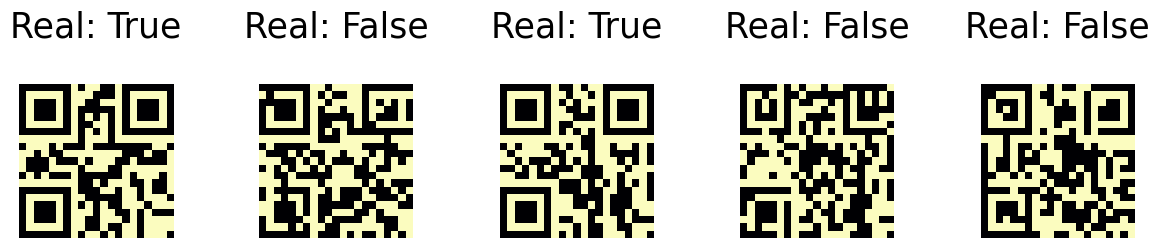

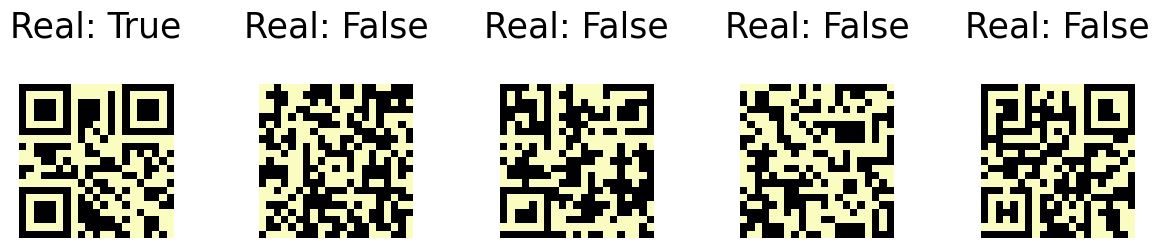

In [29]:
plot_codes(X_train[:5, :], y_true=y_train[:5])
plot_codes(X_train[5:10, :], y_true=y_train[5:10])

## Шаг 4. Построение персептрона.

In [30]:
class Perceptron:
  def __init__(self, hidden_layers : List[int], 
               activations: List[Callable], 
               eta:Union[int, float] = 1, 
               n_epochs: int = 100,
               random_weights=None):
    self.layers = []
    self.epochs = n_epochs
    self.eta = eta
    self.errors = []
    l = hidden_layers + [1]
    for i in range(len(hidden_layers)):
      self.layers.append(Layer((l[i]+1, l[i+1]), activations[i], i + 1, random_weights=random_weights))

  def predict(self, train_sample: NDArray, logging: bool = False) -> NDArray:
    result = np.zeros(train_sample.shape[0])
    for i in range(train_sample.shape[0]):
      x = train_sample[i, :]
      for layer in self.layers:
        x = np.append(x, values=[1]) # добавление свободного коэффициента
        x = layer.forward(x, logging)
        
      result[i] = x[0]
      if logging:
        print(result[i])
    return result

  def train(self, train_sample: NDArray, 
            train_ans: NDArray, 
            logging=False,
            activation=np.sign,
            random_weights=None) -> list[float]:
    self.layers = [Layer((train_sample.shape[1]+1, 
                          self.layers[0].size[0]-1), 
                          activation, 
                          0, 
                          random_weights=random_weights)] + self.layers # инициализация сенсоров
    for _ in range(self.epochs):
      train_sample, train_ans = shuffle(train_sample, train_ans) 
      error = 0
      for i in range(train_sample.shape[0]):
        x = train_sample[i, :]
        for layer in self.layers:
          x = np.append(x, values=[1]) # добавление свободного коэффициента
          x = layer.forward(x, logging)
        # вычисление ошибки
        ans = x[0]
        delta = train_ans[i] - ans
        error += abs(delta)
        # пересчет весов
        for layer in self.layers:
          layer.backward(self.eta*delta)
      self.errors.append(error)
    return self.errors


class Layer:
  def __init__(self, 
               size: tuple[int, int], 
               activation: Callable, 
               index: int, 
               value: Union[int, float]=0,
               random_weights=None):
    self.size = size
    self.w = np.full(size, value)
    if random_weights is not None:
      self.w = np.random.randint(random_weights[0], random_weights[1], self.size)
    self.activation = np.vectorize(activation)
    self.i = index
    self.last_result = np.array([])
    self.last_x = np.array([])

  def backward(self, value) -> None:
    if value > 0: 
      # надо увеличить те веса, где нет активации,
      # но должна быть активация  
      d = (self.last_x>0)*value
      d = np.repeat(np.array([d]).T, self.w.shape[1], axis=1)
      self.w = self.w + d
    if value < 0: 
      # надо уменьшить те веса, 
      # где активации быть не должно
      d = (self.last_x>0)*value
      d = np.repeat(np.array([d]).T, self.w.shape[1], axis=1)
      self.w = self.w + d

  def forward(self, x, logging) -> NDArray:
    if logging:
      print(f"Слой №{self.i+1}")
      print(f"Сенсоры  : {x}")
      print(f"Размер: {self.size}")
      
    m = np.dot(x, self.w)
    result = self.activation(m)
    self.last_result = result
    self.last_x = x
    if logging:
      print(f"Сумматор : {m}")
      print(f"Активация: {result}")
      print(f"Результат размера {result.shape}")
    
    return result

## Шаг 5. Обучение персептрона

In [31]:
pcp = Perceptron([1], [np.sign], n_epochs=100)
errors = pcp.train(X_train, 
                   y_train, 
                   logging=False, 
                   activation=np.sign,)

Обучили на 100 эпохах

## Шаг 6. Визуализация весов персептрона

Text(0.5, 1.0, 'Веса персептрона 1 слоя')

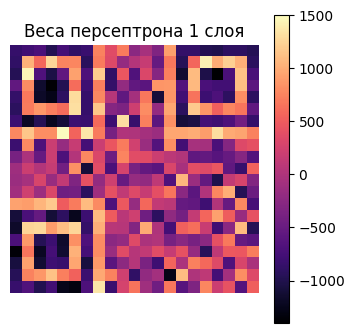

In [32]:
w = pcp.layers[0].w[:441, :]
show_code(w, vmax=np.max(w), vmin=np.min(w), colorbar=True)
plt.title("Веса персептрона 1 слоя")

Можно заметить, что веса получились достаточно большие по модулю

## Шаг 7. Оценка качества обучения по эпохам

Размерность слоёв:  (442, 1) (2, 1)


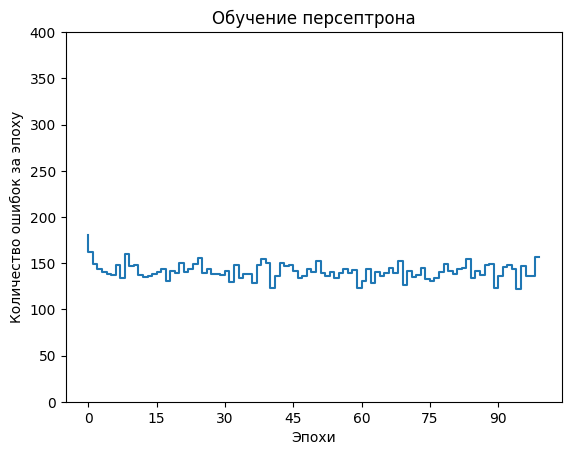

In [35]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.step([i for i in range(len(errors))], errors)
plt.ylim((0, X_train.shape[0]))
plt.xlabel("Эпохи")
plt.ylabel("Количество ошибок за эпоху")
plt.title("Обучение персептрона")
print("Размерность слоёв: ", *[i.size for i in  pcp.layers])

Судя по графику ошибок по эпохам, можно сказать, что персептрон расходится

## Шаг 8. Оценка качества классификации

Создаём валидационную выборку из 20 правильных и 20 неправильных изображений

In [36]:
n = 20
alpha = 0.1
X_val = np.array([crash_code(create_code(), alpha) for i in range(n//2)] +
              [create_noise() for i in range(n//2)] +
              [create_code() for i in range(n)])
y_val = np.array([0]*n + [1]*n)
y_val_pred = pcp.predict(X_val)

print('Accuracy:', acc(y_val, y_val_pred))
print('Recall:', rec(y_val, y_val_pred))
print('Precision:', pre(y_val, y_val_pred))

Accuracy: 0.675
Recall: 1.0
Precision: 0.6060606060606061


Видим, что результаты оставляют желать лучшего.

## Шаг 9. Другая модель и исследования

Мы запускали по многу раз первую модель, но положительных результатов она не дала

Для решения этой задачи мы пробовали собирать полносвязные нейросети, состоящие из разного количества слоёв и нейронов, разных функций активации.

Ниже будет представен лучший вариант из тех, что пробовали.

In [106]:
ReLU = lambda x: max(0, x)
step = lambda x: int(x >= 0)
pcp = Perceptron([441], [step], n_epochs=20)
errors = pcp.train(X_train, y_train, logging=False, activation=ReLU, random_weights=[-100, 100])

Тут создали двухслойную нейросеть. Слои полносвязные. В первом слое 441 сенсоров и 441 нейроно, во втором слое 441 сенсоров и 1 нейрон. Веса инициилизируются случайными числами от -100 до 100. В первом слое функция активации ReLU, во втором слое функция-шаг.

Размерность слоёв:  (442, 441) (442, 1)


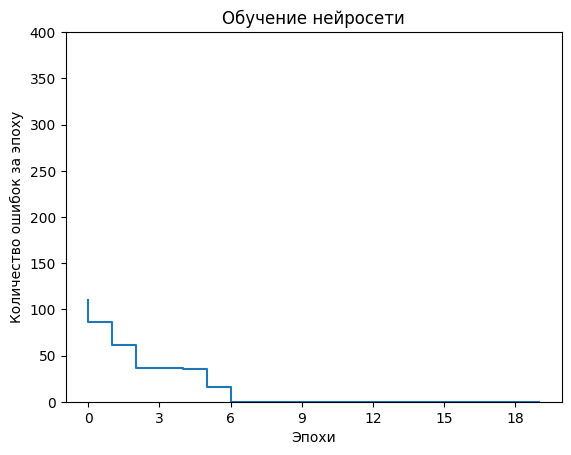

In [108]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.step([i for i in range(len(errors))], errors)
plt.ylim((0, X_train.shape[0]))
plt.xlabel("Эпохи")
plt.ylabel("Количество ошибок за эпоху")
plt.title("Обучение нейросети")
print("Размерность слоёв: ", *[i.size for i in  pcp.layers])

Судя по графику нейросеть сошлась, и, достаточно быстро. Выведем веса.

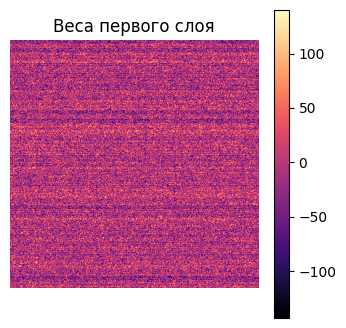

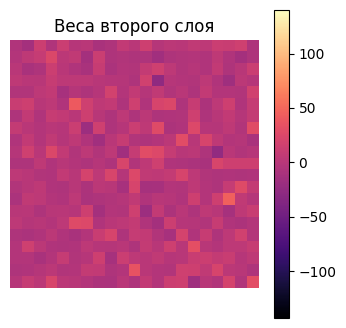

In [109]:
w1 = pcp.layers[0].w[:441, :]
w1 = w1.reshape(w1.shape[0]*w1.shape[1], 1)[:, 0]
w2 = pcp.layers[1].w[:441, :]
w2 = w2.reshape(w2.shape[0]*w2.shape[1], 1)[:, 0]
vmax = max(np.max(w1), np.max(w2))
vmin = min(np.min(w1), np.min(w2))
show_code(w1, vmax=vmax, vmin=vmin, colorbar=True)
plt.title("Веса первого слоя")
show_code(w2, vmax=vmax, vmin=vmin, colorbar=True)
plt.title("Веса второго слоя")
print()

Интерересная картинка, ничего непонятно, но зато работает.

Посчитаем метрики на той же валидационной выборке

In [110]:
y_val_pred = pcp.predict(X_val)

print(f'Accuracy: {acc(y_val, y_val_pred):.03f}', )
print(f'Recall: {rec(y_val, y_val_pred):.03f}')
print(f'Precision: {pre(y_val, y_val_pred):.03f}')

Accuracy: 0.950
Recall: 1.000
Precision: 0.909


Видим что метрики очень хорошие 

## Другая задача

Тут нам стало интересно запустить нейросеть для решения другой задачи, на наш взгляд более интересной. А именно классическая задача распозначания рукописных цифр.

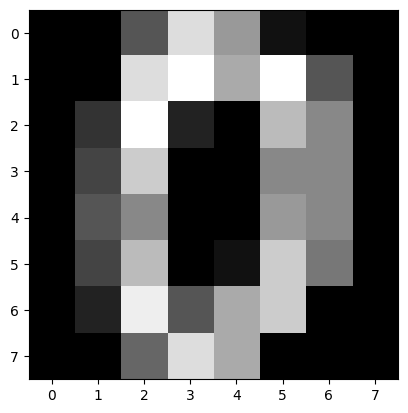

In [16]:
from sklearn.datasets import load_digits
digits = load_digits()

plt.imshow(digits.images[0], cmap='gray')

In [120]:
relu = lambda x: np.maximum(0, x)
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target==0, test_size=0.2, random_state=42)

pcp = Perceptron([441], [step], n_epochs=20)
errors = pcp.train(X_train, y_train , logging=False, activation=ReLU, random_weights=[-100, 100])

Размерность слоёв:  (65, 441) (442, 1)


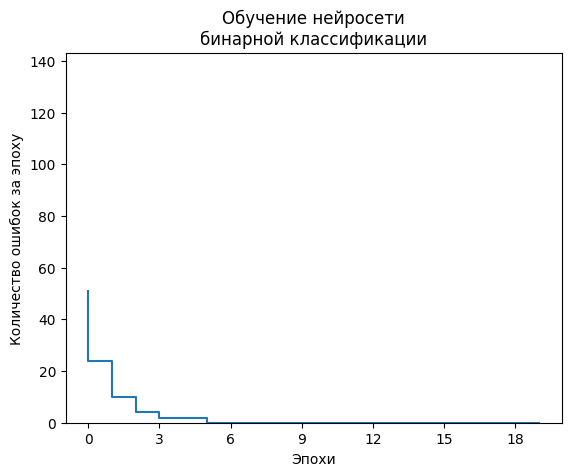

In [122]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.step([i for i in range(len(errors))], errors)
plt.ylim((0, X_train.shape[0]//10))
plt.xlabel("Эпохи")
plt.ylabel("Количество ошибок за эпоху")
plt.title("Обучение нейросети\nбинарной классификации")
print("Размерность слоёв: ", *[i.size for i in  pcp.layers])

Видим что нейросеть сошлась, посмотрим на метрики

In [19]:
y_pred = pcp.predict(digits.data)
y_pred_test= pcp.predict(X_test)

print(f'Accuracy all: {acc(y_pred, digits.target==0):.03f}', )
print(f'Recall all: {rec(y_pred, digits.target==0):.03f}')
print(f'Precision all: {pre(y_pred, digits.target==0):.03f}')
print()
print(f'Accuracy test: {acc(y_pred_test, y_test):.03f}', )
print(f'Recall test: {rec(y_pred_test, y_test):.03f}')
print(f'Precision test: {pre(y_pred_test, y_test):.03f}')

Accuracy all: 0.999
Recall all: 1.000
Precision all: 0.994

Accuracy test: 0.997
Recall test: 1.000
Precision test: 0.970


Метрики тоже очень хорошие

Text(0.5, 1.0, 'Is zero? True')

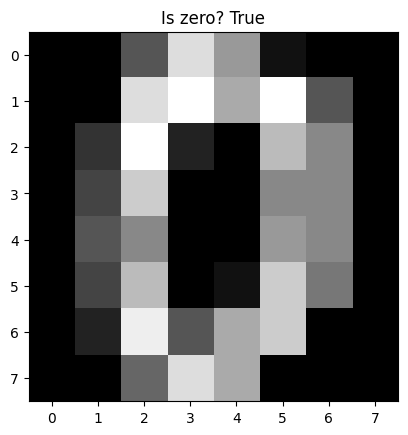

In [20]:
plt.imshow(digits.images[0], cmap='gray')
plt.title(f'Is zero? {bool(y_pred[0])}')

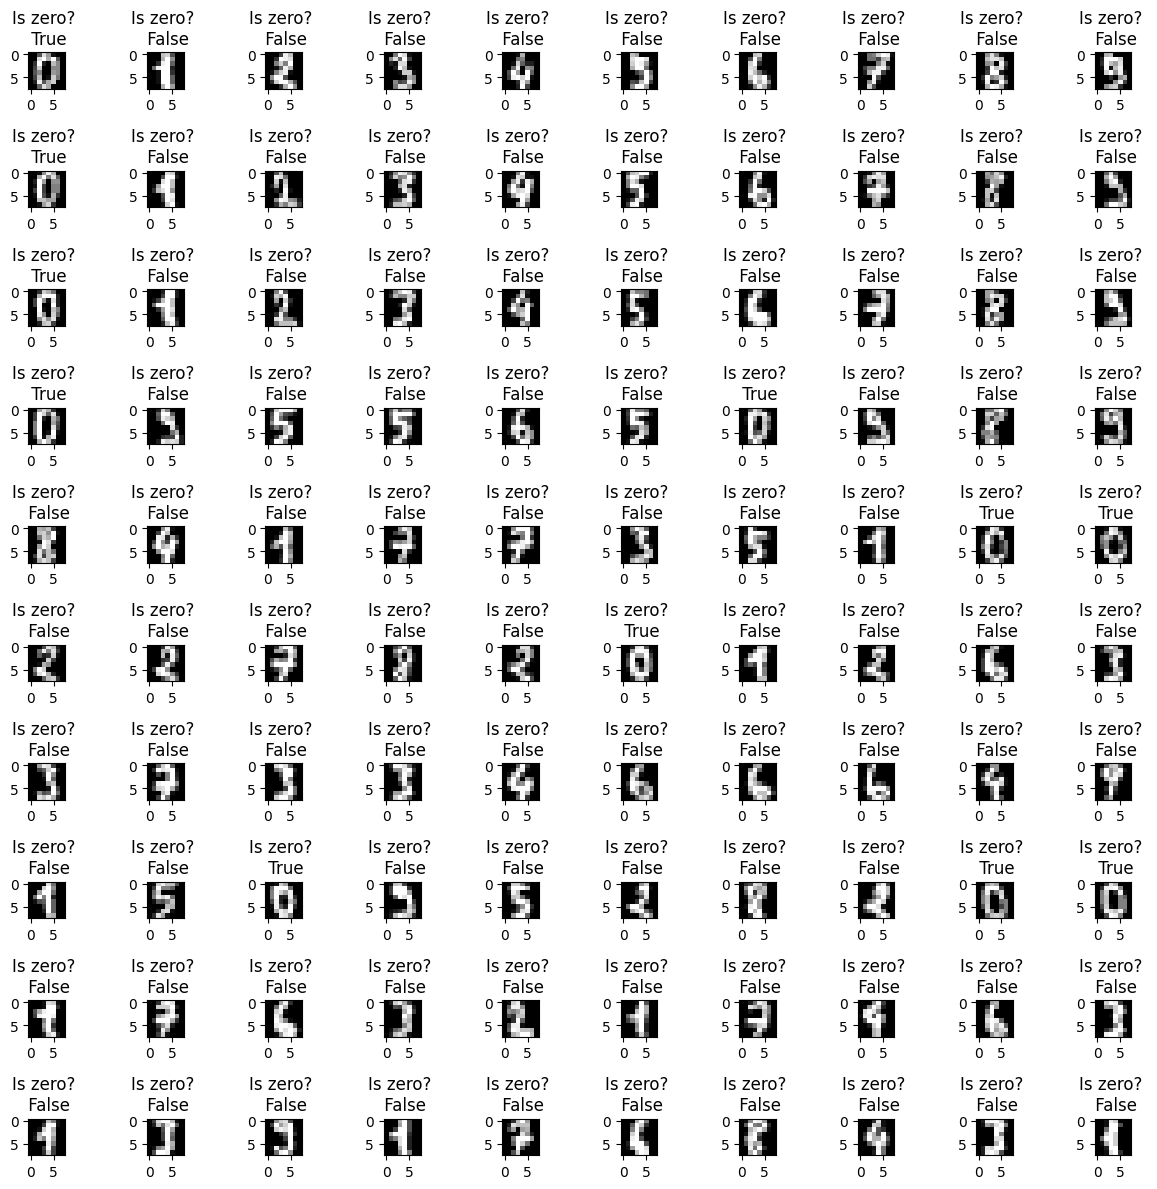

In [21]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i + 1)  # Создаем подграфик
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(f'Is zero? \n {bool(y_pred[i])}')
plt.tight_layout()

## Выводы

1. Данный метод обучения достаточно плохо сходится. Вероятно, из-за того, что мы не считаем градиент.
2. Однойслойный перцептрон проигрывает двуслойной полносвязной нейросети в контексте данных задач.
3. Перемешивание обучающей выборки каждую эпоху позитивно скизывается на обучении. Модель обучается более стабильно.
4. Пока что наша модель годится только для бинарной классификации. Мы пока что думаем как это исправить.
5. Инициализация весов случайными значениями очень помогает сойтись нейросети. Это происходит из-за того, что нейроны одного слоя получают разные стартовые веса, в процессе обучения каждый из них обновляет веса по-своему и улавливает что-то своё. Если инициализировать веса одинаковыми значениями, то все нейроны у нас получаются одинаковые - теряется смысл. 
6. Проверили нейросеть для разных задач. Работает. В данном случае функция активации ReLU на первом слое и функция-шаг на втором слое показывают себя хорошо.
7. Для каждой задачи нужно подбирать свою архитектуру: количество слоёв, размеры, функции активации. Скорее всего нет универсального решения.